# Семинар 7. Решающие деревья. Ансамбли моделей

Полезные материалы:

- [Decision Trees](https://mlu-explain.github.io/decision-tree/)
- [Random Forest](https://mlu-explain.github.io/random-forest/)
- [Out-of-Bag Errors for Random Forest](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py)
- [Bias-Variance Tradeoff](https://mlu-explain.github.io/bias-variance/)

In [1]:
# !pip install ucimlrepo
# !uv pip install ucimlrepo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_gaussian_quantiles, make_moons
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score

from ucimlrepo import fetch_ucirepo 

sns.set_theme(style="whitegrid")

## Часть 1. Решающие деревья

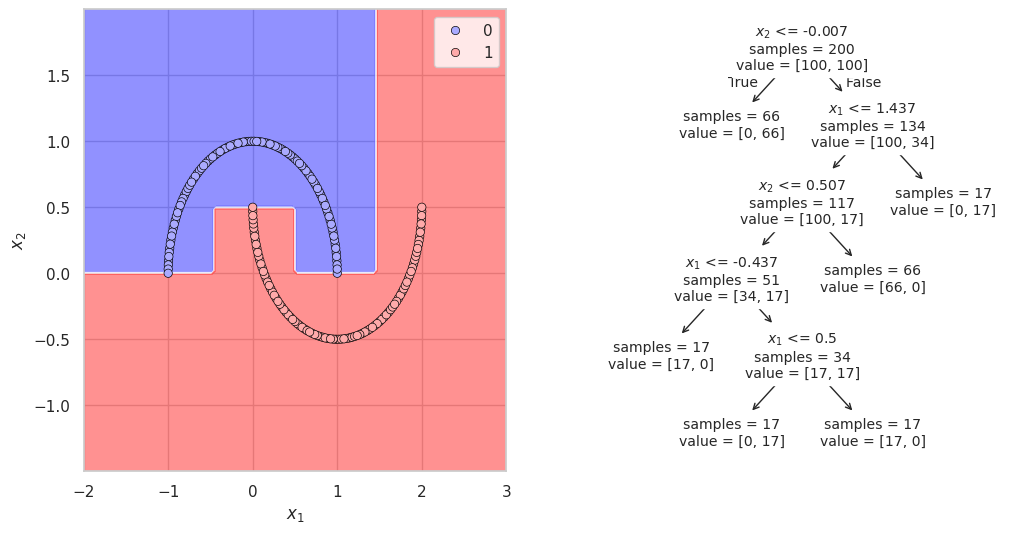

In [3]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 6)

X, y = make_moons(n_samples=200, random_state=451)

clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    response_method="predict",
    ax=axs[0],
    cmap="bwr",
    alpha=0.5,
)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="bwr", edgecolor="black", ax=axs[0])
axs[0].set_xlabel("$ x_1 $")
axs[0].set_ylabel("$ x_2 $")

plot_tree(clf, feature_names=["$ x_1 $", "$ x_2 $"], impurity=False, ax=axs[1])
plt.show()

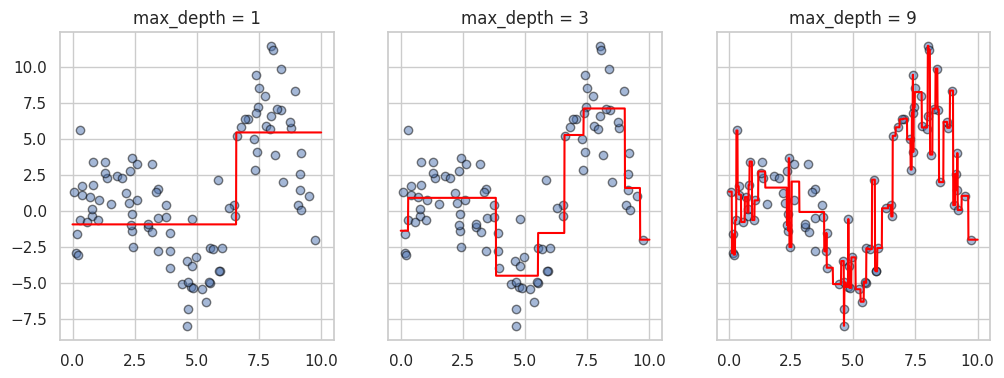

In [4]:
X = np.random.uniform(0, 10, size=100)
y = np.sin(X) * X + np.random.normal(scale=2.0, size=100)

X = X[:, None]
x_ = np.linspace(0, 10, num=1_000)[:, None]

fig, axs = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(12, 4)

for max_depth, ax in zip((1, 3, 9), axs):
    reg = DecisionTreeRegressor(max_depth=max_depth).fit(X, y)
    y_ = reg.predict(x_)
    ax.plot(x_, y_, color="red")
    ax.scatter(X, y, alpha=0.5, edgecolors="black")
    ax.set_title(f"{max_depth = }")
    
plt.show()

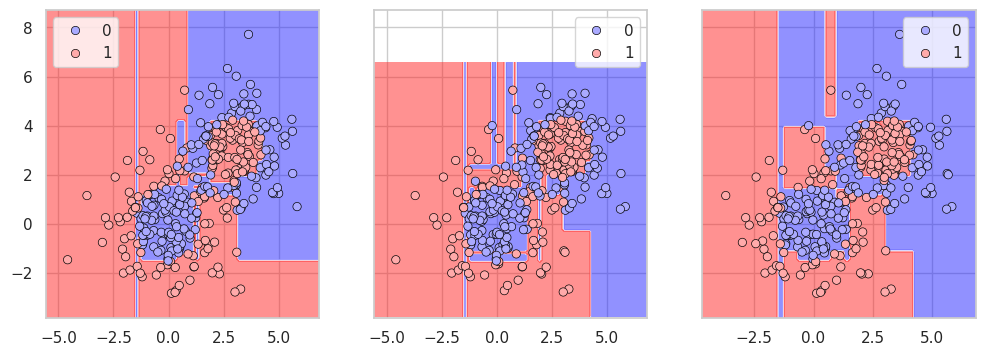

In [5]:
X1, y1 = make_gaussian_quantiles(
    cov=2.0,
    n_samples=200,
    n_features=2,
    n_classes=2,
    random_state=42,
)
X2, y2 = make_gaussian_quantiles(
    mean=(3, 3),
    cov=1.5,
    n_samples=200,
    n_features=2,
    n_classes=2,
    random_state=42,
)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, -y2 + 1))

fig, axs = plt.subplots(1, 3, sharey=True)
fig.set_size_inches(12, 4)

for i, ax in enumerate(axs):
    mask = np.random.uniform(size=400) < 0.8
    X_sample, y_sample = X[mask], y[mask]

    clf = DecisionTreeClassifier().fit(X_sample, y_sample)

    DecisionBoundaryDisplay.from_estimator(
        clf,
        X_sample,
        response_method="predict",
        ax=ax,
        cmap="bwr",
        alpha=0.5,
    )
    sns.scatterplot(x=X_sample[:, 0], y=X_sample[:, 1], hue=y_sample, palette="bwr", edgecolor="black", ax=ax)

## Часть 2. Ансамбли (композиции) моделей

### Bagging (**b**ootstrap **agg**regat**ing**). Случайный лес (Random Forest)

In [6]:
from sklearn.ensemble import RandomForestClassifier, RandomForestClassifier

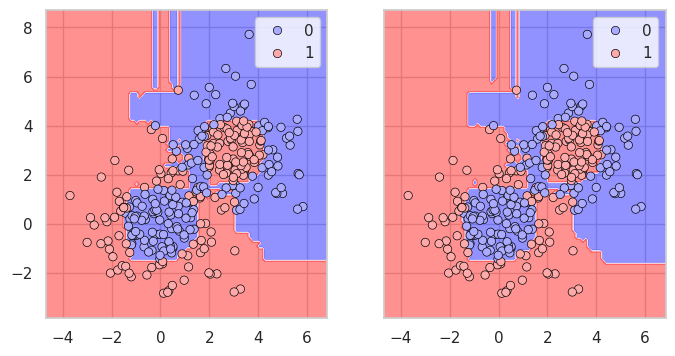

In [7]:
fig, axs = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(8, 4)

for i, ax in enumerate(axs):
    clf = RandomForestClassifier(n_estimators=500).fit(X, y)
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X_sample,
        response_method="predict",
        ax=ax,
        cmap="bwr",
        alpha=0.5,
    )
    sns.scatterplot(x=X_sample[:, 0], y=X_sample[:, 1], hue=y_sample, palette="bwr", edgecolor="black", ax=ax)

### Boosting

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

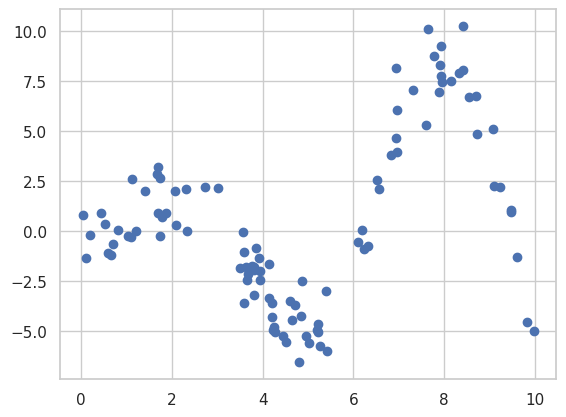

In [9]:
X = np.random.uniform(0, 10, size=100)
y = np.sin(X) * X + np.random.normal(size=100)

plt.scatter(X, y)
plt.show()

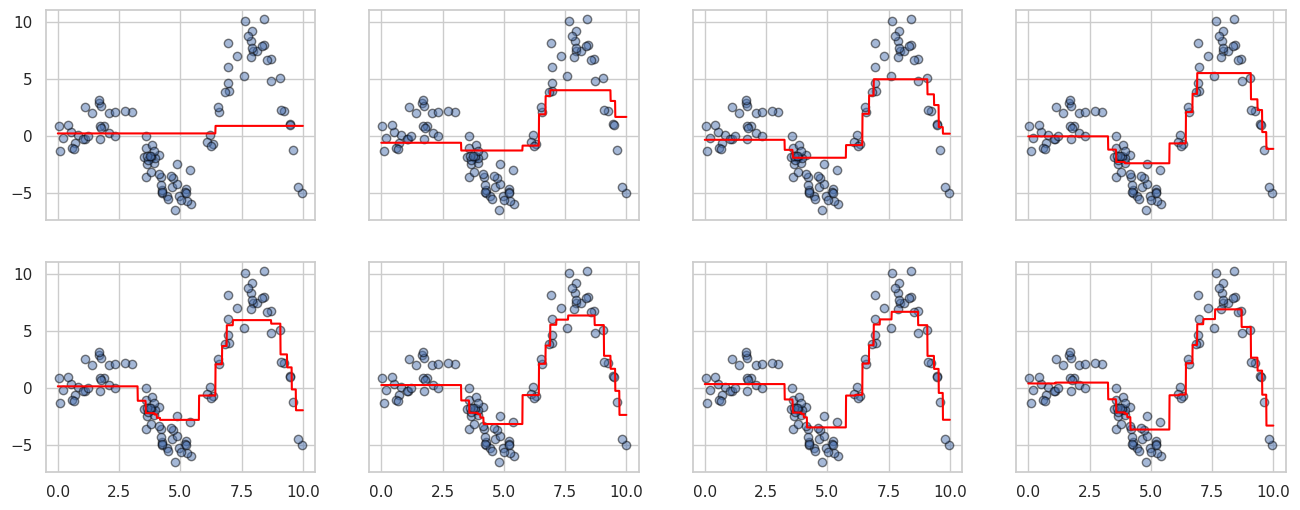

In [10]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(16, 6)

X = X[:, None]
x_ = np.linspace(0, 10, num=1_000)[:, None]

reg = GradientBoostingRegressor(n_estimators=160, max_depth=1).fit(X, y)

axs = iter(axs.flat)

for i, y_ in enumerate(reg.staged_predict(x_)):
    if i % 20 == 0:
        ax = next(axs)
        ax.plot(x_, y_, color="red")
        ax.scatter(X, y, alpha=0.5, edgecolors="black")

plt.show()

Популярные имплементации градиентного бустинга:
- [CatBoost](https://catboost.ai/) алгоритм градиентного бустинга, разработанный в Яндекс  
        + работает с категориальными признаками,  
        + поддерживает обучение на GPU  
        и многое др.
- [XGBoost](https://xgboost.readthedocs.io/en/stable/)
- [LightGBM](https://lightgbm.readthedocs.io/en/stable/)

In [11]:
# !pip install catboost
# !uv pip install catboost

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from catboost import CatBoostClassifier, CatBoostRegressor

In [13]:
adult = fetch_ucirepo(id=2) 
  
X = adult.data.features 
y = adult.data.targets 
  
# print(adult.metadata) 
# print(adult.variables)

In [14]:
X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [15]:
X.nunique()

age                  74
workclass             9
fnlwgt            28523
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        123
capital-loss         99
hours-per-week       96
native-country       42
dtype: int64

In [16]:
y.head()

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


In [17]:
X.isna().sum()

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64

In [18]:
X["workclass"].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked',
       nan], dtype=object)

In [19]:
X["occupation"].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', '?', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv', nan], dtype=object)

In [20]:
X["native-country"].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands', nan], dtype=object)

In [21]:
COLUMNS_TO_FILL_NANS = ["workclass", "occupation", "native-country"]

X.loc[:, COLUMNS_TO_FILL_NANS] = X.loc[:, COLUMNS_TO_FILL_NANS].fillna("Unknown").replace({"?": "Unknown"})
X.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64

In [22]:
y["income"].unique()

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

In [23]:
y = (y["income"].str.rstrip(".") == ">50K").astype(int)
y.unique()

array([0, 1])

<Axes: xlabel='income'>

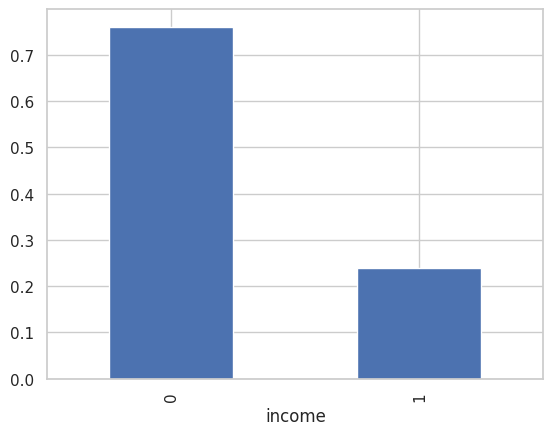

In [24]:
y.value_counts(normalize=True).plot.bar()

In [25]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=42, stratify=y_train_val)

print(y_train.size, y_val.size, y_test.size)

27473 9158 12211


In [26]:
CATEGORICAL_FEATURES = X.select_dtypes("object").columns.to_list()
CATEGORICAL_FEATURES

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [27]:
clf = CatBoostClassifier(
    depth=3,
    auto_class_weights="Balanced",
    eval_metric="F1",
)
clf.fit(
    X_train,
    y_train,
    cat_features=CATEGORICAL_FEATURES,
    eval_set=(X_val, y_val),
    use_best_model=True,
)

Learning rate set to 0.071832
0:	learn: 0.8013712	test: 0.8010753	best: 0.8010753 (0)	total: 86.8ms	remaining: 1m 26s
1:	learn: 0.8012457	test: 0.8010753	best: 0.8010753 (0)	total: 135ms	remaining: 1m 7s
2:	learn: 0.7997635	test: 0.7985603	best: 0.8010753 (0)	total: 150ms	remaining: 49.7s
3:	learn: 0.8019241	test: 0.8019363	best: 0.8019363 (3)	total: 163ms	remaining: 40.7s
4:	learn: 0.8022651	test: 0.8015455	best: 0.8019363 (3)	total: 175ms	remaining: 34.8s
5:	learn: 0.8053234	test: 0.8047180	best: 0.8047180 (5)	total: 187ms	remaining: 31s
6:	learn: 0.8044488	test: 0.8046419	best: 0.8047180 (5)	total: 204ms	remaining: 28.9s
7:	learn: 0.8042836	test: 0.8037469	best: 0.8047180 (5)	total: 226ms	remaining: 28s
8:	learn: 0.8115551	test: 0.8129806	best: 0.8129806 (8)	total: 241ms	remaining: 26.5s
9:	learn: 0.8069241	test: 0.8076249	best: 0.8129806 (8)	total: 263ms	remaining: 26s
10:	learn: 0.8135120	test: 0.8157316	best: 0.8157316 (10)	total: 280ms	remaining: 25.1s
11:	learn: 0.8139177	test:

In [28]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      9289
           1       0.60      0.86      0.71      2922

    accuracy                           0.83     12211
   macro avg       0.77      0.84      0.79     12211
weighted avg       0.86      0.83      0.84     12211



In [29]:
scores = clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, scores))

0.9282118443362793
